# MERFISH Analysis
This notebook contains code for a basic analysis pipeline of MERFISH data.  
The analysis is based on the segmented cells and the calculated gene count matrix. The analysis is done using the common scverse packages AnnData, ScanPy and SquidPy.

## Imports

In [ ]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import scanpy as sc
import squidpy as sq

# Suppress warnings
sc.settings.verbosity = 0
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Import data

In [ ]:
DATA_PATH = os.path.join(os.getcwd(), 'data/data202309291351/region_0/')

## Import processed merfish data

### Squidpy - VizGen importer
SquidPy provides a set of import functions to easily import data that was processed with common analysis tools.  
Output files from platforms such as `10x Visium` or `VizGen` can directly be imported.  

The following example loads the files generated by `Vizgen`:   
```
vizgen_ad = sq.read.vizgen(
    path=merfish_data_path,
    counts_file=gene_count_file_name,
    meta_file=cell_meta_data_file_name,
    transformation_file=transformation_file_name,
)
```

For our purpose we will build an AnnData object ourself using the dataframes generated from by the Baysor segmentation algorithm.

### Squidpy - AnnData importer

### Import dataframes
Import the necessary dataframes that contain the meta information of the segmented cells as well as the gene count matrix.  

In [ ]:
gene_counts_file_path = os.path.join(DATA_PATH, "cell_by_gene.csv")
gene_counts_df = pd.read_csv(gene_counts_file_path, header=0)

gene_counts_df.head()

In [ ]:
cell_meta_data_file_path = os.path.join(DATA_PATH, "cell_metadata.csv")
cell_meta_data_df = pd.read_csv(cell_meta_data_file_path)

cells = gene_counts_df.index.tolist()

print(f"The tissue slices contains {len(cells)} segmented cells.")
cell_meta_data_df.head()

In [ ]:
# Rename some columns to match test datasets
cell_meta_data_df.rename(columns={"center_x": "x", "center_y": "y", "volume": "area"}, inplace=True)
cell_meta_data_df.head()

### Drop genes and blanks
The overall goal of these data analysis steps is to find clusters and its correlations with certain genes.  
Genes that are highly expressed in most cells might be too strong of a signal for clustering and correlation analysis.  
To improve clustering and data analysis one might consider to remove some of the very common genes.
On top of removing these genes, we also remove all the blanks that were used during the imaging process.

In [ ]:
# Specify common genes to be removes.
DROP_GENES = [""]
# Remove the specified genes from the gene count matrix
keep_genes = [gene for gene in gene_counts_df.columns if gene not in DROP_GENES]
gene_counts_df = gene_counts_df[keep_genes]
#gene_counts_df.head()


# Remove the blanks from the gene count matrix
DROP_BLANK = 'Blank*'
columns_to_drop = gene_counts_df.filter(regex=DROP_BLANK, axis=1).columns
print(f"Found (and removed) {len(columns_to_drop)} blank runs.")
gene_counts_df.drop(columns=columns_to_drop, inplace=True)
gene_counts_df.head()

### AnnData object
We now build an Anndata object using the cell meta data and transcripts dataframes:

In [ ]:
gene_metadata_df = pd.DataFrame(index=gene_counts_df.columns.tolist())
gene_counts_df = gene_counts_df[keep_genes]
gene_metadata_df = gene_metadata_df.loc[keep_genes]

# Create AnnData object
merfish_ad = sc.AnnData(X=gene_counts_df.values, obs=cell_meta_data_df, var=gene_metadata_df)
merfish_ad

In [ ]:
merfish_ad

### Add spatial data
Once we have created the AnnData object based on the cell meta data, we can add the spatial coordinates of the decoded transcripts.

In [ ]:
spatial_cell_coordinates = cell_meta_data_df[['x', 'y']].values
merfish_ad.obsm['spatial'] = np.transpose(spatial_cell_coordinates.transpose())

In [ ]:
merfish_ad

## Preprocessing

### Filter the data
Remove cells and genes with low counts:  
The goal of this step is to remove genes and cells which most 

Both during spot calling and cell segmentation the algorithms might sometimes output wrong or meaningless results.  
If a segmented cell contains almost or no detected transcripts we might want to remove it. 
Similarly we want to filter the genes: If only a very small number of transcripts of a certain gene are found we want to remove this genes. Such genes not contribute to later analysis and thus can be removed.  

`MIN_COUNTS_PER_CELL` : Minimum number of counts required for a gene to pass filtering.  
Setting MIN_COUNTS_PER_CELL to 1 ensure our analysis will not include empty cells.  
`MIN_CELLS_PER_GENE` :  Minimum number of cells expressed required for a gene to pass filtering.

We could also define corresponding max values. See the [function API](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_genes.html) for more details. 

In [ ]:
MIN_COUNTS_PER_CELL = 10
MIN_CELLS_PER_GENE = 30
sc.pp.filter_cells(merfish_ad, min_counts=MIN_COUNTS_PER_CELL, inplace=True)
sc.pp.filter_genes(merfish_ad, min_cells=MIN_CELLS_PER_GENE, inplace=True)

### Quality control
Before we start clustering the data we need to apply some basic quality control.  
ScanPy provides functionality to easily calculate some basic QR metrics. The goal of these metrics is the estimate the distribution of transcripts within the segmented cells.  
Similarly to the previous step where we filtered cells with (almost) no decoded spots, we want to make see how the transcripts per cell are distributed.


The following two values are the most basic QR metrics:  
**total_counts:** Total number of counts (spots) for a cell.  
**n_genes_by_counts:** The number of genes with at least 1 count in a cell. Calculated for all cells.  

Calculating and plotting these values can give us an idea how well the transcipts are distributed across cells.  
If for example a large number of cells have only a few transcripts we might want to check the output of our segmentation pipeline. It might be that many cells have not be segmented properly.  
For more details see: [API](https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.calculate_qc_metrics.html)

#### Abstract example
To have a more intuetive understanding of the two main QR metrics let's have a look at this abstract example of a cell and the decoded transcripts:  

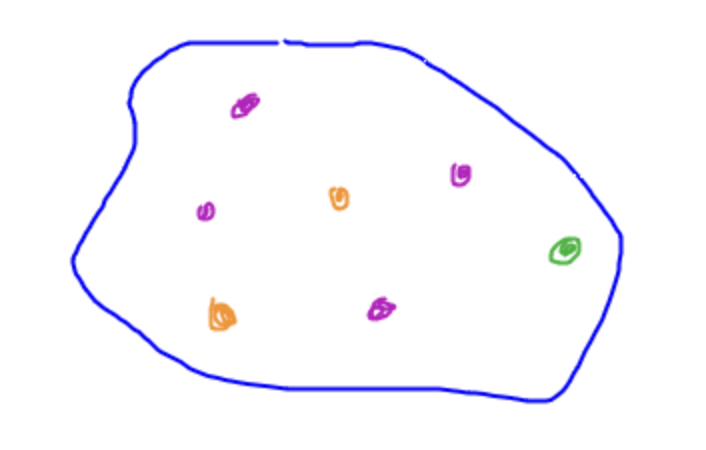


The processing pipeline decoded 7 transcripts in total: 4 purple genes, 2 orange genes and one green.  
Therefore the total number of transcripts (`total_counts`) is 7 and the number of genes with at least one transcript (`n_genes_by_counts`) is 3.  
=> total_counts = 7  
=> n_genes_by_counts = 3

In [ ]:
sc.pp.calculate_qc_metrics(merfish_ad, percent_top=None, log1p=False, inplace=True)

#### Plot QR distribution
To have an estimated on the distribution of these QR metrics lets plot a histogram of them.  
In addition to the QR metrics calculated by ScanPy we might want to other values outputted by the segmentation algorithm:
These values can give us additional hints about the quality of the data. In this example we plot the areas of the segmented cells (in pixels) and the average confidence values of each transcript assigned to the cells.  
The confidence value is calculated by the data processing pipeline during spot calling and averaged during segmentation.  
There are many more possible metrics that might be plotted here. 

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    merfish_ad.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    merfish_ad.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("Area per cell")
sns.histplot(
    merfish_ad.obs["area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Average confidence")
sns.histplot(
    merfish_ad.obs["avg_confidence"],
    kde=False,
    ax=axs[3],
)

#### QR Violin plot
To better visualize the QR metric we can also plot the values in a logarithmic violin plot.  
These violin plots are build into the ScanPy library. For more details check the [documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.violin.html)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
sc.pl.violin(merfish_ad, ['n_genes_by_counts', 'total_counts'], jitter=0.3, stripplot=True, log=True, ax=axs)

### Data normalization
Data normalization is a typical step in most data analysis pipelines (not just for ST data).  
ScanPy again provides built in functionality.

In [ ]:
sc.pp.normalize_total(merfish_ad, inplace=True) # Normalize counts per cell
sc.pp.log1p(merfish_ad) # Logarithmize the data matrix

## Clustering
ScanPy provides build in functionality for many different clustering algorithms such as PCA, UMAP, Leiden clustering ect.  
Using these functionalities makes it incredibly easy to visualize such clusters. ScanPy executes the clustering or dimension reduction and adds the calculated values 
The following cells demonstrate how we can cluster the spatial data and visualize these cluster with only a few lines of code.

In [ ]:
merfish_ad

In [ ]:
sc.pp.pca(merfish_ad, n_comps=50)
sc.pp.neighbors(merfish_ad)
sc.tl.umap(merfish_ad)
sc.tl.leiden(merfish_ad, key_added="clusters", resolution=0.65)

In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(merfish_ad, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

In [ ]:
sc.pl.embedding(merfish_ad, basis="spatial", color="clusters")

### Interactive plots
The built in plotting functions provides by ScanPy are very convenient for quickly create plots.  
However, if we would like to customize our plots or make them interactive to better inspect the data, these static plots are not ideal.  
The following code cell provides an example on how to create a custom Plotly plot using the clusters generated by ScanPy:

In [ ]:
spatial_coords = merfish_ad.obsm["spatial"]
clusters = merfish_ad.obs["clusters"]

fig = go.Figure()

for cluster_label in sorted(clusters.unique(), key=lambda s: int(s)):
    cluster_mask = clusters == cluster_label
    
    x = spatial_coords[cluster_mask, 0]
    y = spatial_coords[cluster_mask, 1]

    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name=f'Cluster {cluster_label}',
        marker=dict(size=5),
    ))

fig.update_layout(
    title={
        'text': "Spatial Embedding with Cluster Coloring",
        'xanchor': 'center',
        'yanchor': 'top',
        'x': 0.5,  # Set x to 0.5 to center the title
    },
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    width=600,  # Set the width of the plot
    height=600,  # Set the height of the plot
    showlegend=True,  # Show the legend
    legend=dict(
        title="Clusters",  # Set the legend title
        orientation="v",  # Set the legend orientation to vertical
        x=1.02,  # Set x to a value greater than 1 to position the legend outside the plot
        y=0.5,  # Set y to 0.5 to center the legend vertically
        bgcolor="rgba(240, 240, 240, 0.6)",  # Set a background color for the legend
    ),
)

fig.show()

### Gene rankings
Although we might be able to visually sense check the clusters on the previous plots, we would like to have a better understanding of them.  
One way of inspecting the clusters is to plot the ranking of genes in each cluster. The following example plots the top 10 genes in each cluster.  
We can observe, that genes are ranked differently in different clusters. The `rank_genes_groups` function calculates the correlation of genes in a given cluster vs. the rest of the clusters.  
These plots can give us an idea about the meaning of the clusters. We might be able to assign a cluster to a certain biological region of the tissue or even to a specific cell type given the different gene expression patterns.  
ScanPy implements different ranking methods such as 't-test', 'wilcoxon' or 'logistic regression'.

In [ ]:
clusters = merfish_ad.obs["clusters"]
sc.tl.rank_genes_groups(merfish_ad, groupby="clusters", method='wilcoxon')
sc.pl.rank_genes_groups(merfish_ad, groupby="clusters", n_genes=10)

### Embedding
Another useful way of inspecting cluster is by visualizing the embedding vs a specific gene.  
In the following plot we visualize the expression of two genes (Clca3b and Vim) in the PCA embedding.  

In [ ]:
sc.pl.embedding(merfish_ad, basis="pca", color=["Gabra1", "Sgk1"])

### Identify spatial regions
Similar to the last plot, where we plotted the expression of genes in the PCA embedding, we can also plot the expression in the spatial coordinates.  
The following example plots the expression of gene three genes in the spatial coordinates. We can see the differences of gene expression depending on the spatial coordinates.  
This  example esentially demonstrates the purpouse of Spatial Trasncriptomics: Using common single cell RNA-seq data, we cannot identofy spatial regions of gene expression! 

In [ ]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.embedding(merfish_ad, basis="spatial", color=["Gabra1", "Sgk1", "Sox8"], cmap='viridis_r')

### Neighborhood graph

Compute the neighborhood graph for later usage.

In [ ]:
sq.gr.spatial_neighbors(merfish_ad, coord_type="generic", spatial_key="spatial")

### Spatial autocorrelation
[documentation](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_merfish.html#spatially-variable-genes-with-spatial-autocorrelation-statistics)

In [ ]:
sq.gr.spatial_autocorr(merfish_ad, mode="moran")

sq.pl.spatial_scatter(merfish_ad, shape=None, color=["Gabra1", "Sgk1"], size=2, cmap='viridis_r')
#sq.pl.spatial_scatter(merfish_ad, shape=None, color=["Acta2", "Txndc5"], size=2, cmap='viridis_r')

### Spatial neighborhood graph
Analyze the relationship between clustered based on spatial proximity:  
We can quantify whether such annotations are spatially enriched. Computing a neighborhood enrichment can help us identify clusters that are neighbors in the tissue of interest. In short, it’s an enrichment score on spatial proximity of clusters: if observations (cells or spots) belonging to a cluster are often close to observations belonging to another cluster, then they will have a high score and will appear to be enriched. On the other hand, if they are far apart, and therefore are seldom neighbors, the score will be low and they can be defined as depleted.  
Ideally the following plot shows high values on the diagonal which would indicated that cells within the same cluster are also close to each other (i.e. spatially correlated).
[source](https://www.sc-best-practices.org/spatial/neighborhood.html)

In [ ]:
sq.gr.nhood_enrichment(merfish_ad, cluster_key='clusters')
sq.pl.nhood_enrichment(merfish_ad, cluster_key="clusters", method="average", figsize=(5, 5))

## Marker genes
One of the most interesting and useful analysis steps is to try to assign the generated clusters to actual biological meaning.  
In the following code cells we try to assign clusters to specific cell types (or groups of cells).  
To do so we have to identify marker genes. These genes are typically already known to be a marker for a specific cell type or tissue region.  

In [ ]:
marker_genes_dict = {
    'Smooth Muscle': ['Gabra1'],
    #'Stromal': ['Vim'],
    'T cells': ['Sgk1', 'Sox8'],
    'Stem + TA': ['Bmp7', 'Sema4d']
}

### Gene expression heatmap
Once we have defined a set of marker genes we can plot a gene expression heatmap of these genes.  
The following indicates that certain clusters can be assign to specific cell types.  
For example we can see that the marker gene for Smooth Muscle cells (Acta2) is only strongly expressed in a single cluster. This cluster (Cluster 2) thus most likely corresponds to muscle cells.

In [ ]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.matrixplot(merfish_ad, marker_genes_dict, 'clusters', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

In [ ]:
sc.pl.embedding(merfish_ad, basis="spatial", color="clusters", groups=['0', '2'], palette=sc.pl.palettes.vega_10)

In [ ]:
sc.pl.embedding(merfish_ad, basis="spatial", color="clusters", groups=['6', '16'], size=20, palette=sc.pl.palettes.vega_20)

InsInstead of the simple heatmap used in the plot above we might also use other plots to visualize the expression of marker genes in specific clusters.

In [ ]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.dotplot(merfish_ad, marker_genes_dict, 'clusters', dendrogram=True)

In [ ]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.heatmap(merfish_ad, marker_genes_dict, groupby='clusters', cmap='viridis', dendrogram=True)